In [1]:
import numpy as np
import pandas as pd
import os
import os.path as path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU, Input, SpatialDropout1D,Flatten, Dropout,GlobalMaxPooling1D,Conv1D,MaxPooling1D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.regularizers import l2
import re
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, confusion_matrix,balanced_accuracy_score, make_scorer, precision_recall_fscore_support
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from google.colab import files

Using TensorFlow backend.


In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
from google.colab import drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


In [4]:
from google.colab import files
uploaded = files.upload()

Saving GTNT_training.csv to GTNT_training.csv


In [26]:
df = pd.read_csv("GTNT_training.csv", delimiter=',', header=None,names=['id','t','label'])

In [27]:
print(df)

            id                                                  t  label
0          NaN                                                  t  label
1          3.0    God said Let there be light and there was light    0.0
2          8.0  God called the expanse sky There was evening a...    0.0
3         12.0  The earth brought forth grass herbs yielding s...    0.0
4         13.0  There was evening and there was morning a thir...    0.0
...        ...                                                ...    ...
9996   31094.0  I am the Alpha and the Omega the First and the...    1.0
9997   31096.0  Outside are the dogs the sorcerers the sexuall...    1.0
9998   31098.0  The Spirit and the bride say Come! He who hear...    1.0
9999   31099.0  I testify to everyone who hears the words of t...    1.0
10000  31101.0  He who testifies these things says Yes I come ...    1.0

[10001 rows x 3 columns]


In [28]:
# Prepare predicted labels
df = df.iloc[1:]
Y = df.label
Y_series=pd.Series(Y,dtype='category')
Y = Y_series.cat.codes
y_prep = to_categorical(Y)
print(y_prep.shape)
print(Y_series)

(10000, 2)
1        0.0
2        0.0
3        0.0
4        0.0
5        0.0
        ... 
9996     1.0
9997     1.0
9998     1.0
9999     1.0
10000    1.0
Name: label, Length: 10000, dtype: category
Categories (2, object): [0.0, 1.0]


In [29]:
# Create and fit tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.t)
vocab_size = len(tokenizer.word_index) + 1
word_index = tokenizer.word_index
prep_data = tokenizer.texts_to_sequences(df.t)

In [30]:
prep_data = pad_sequences(prep_data, maxlen=200,padding="post")

In [31]:
print(len(prep_data))
print(len(Y))

10000
10000


In [32]:
# prepare train, test and validation data
X_train, X_test, y_train, y_test = train_test_split(prep_data, y_prep, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(prep_data, y_prep, test_size=0.25, random_state=42)

In [33]:
def get_model(embed,dropout,neurons):
    model = Sequential()
    model.add(Embedding(vocab_size, output_dim=embed, input_length=200))
    model.add(Dropout(dropout))
    model.add(Conv1D(neurons,5,activation='sigmoid'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(2, activation='sigmoid'))
    optimizer=Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy', 
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [34]:
embedding1 = 128
embedding2 = 256
embedding3 = 512
dropout1 = 0.3
dropout2 = 0.5
dropout3 = 0.7
neuron1 = 32
neuron2 = 64
neuron3 = 128

In [35]:
model1 = get_model(embedding2, dropout2, neuron1)
model2 = get_model(embedding2, dropout2, neuron2)
model3 = get_model(embedding2, dropout2, neuron3)

In [36]:
history1 = model1.fit(X_train, y_train, epochs=20,batch_size=32,validation_data=(X_val,y_val))
history2 = model2.fit(X_train, y_train, epochs=20,batch_size=32,validation_data=(X_val,y_val))
history3 = model3.fit(X_train, y_train, epochs=20,batch_size=32,validation_data=(X_val,y_val))

Epoch 1/20
235/235 [==============================] - 7s 32ms/step - loss: 0.6084 - accuracy: 0.7385 - val_loss: 0.4283 - val_accuracy: 0.8648
Epoch 2/20
235/235 [==============================] - 7s 32ms/step - loss: 0.3154 - accuracy: 0.8897 - val_loss: 0.2670 - val_accuracy: 0.9012
Epoch 3/20
235/235 [==============================] - 7s 30ms/step - loss: 0.1811 - accuracy: 0.9412 - val_loss: 0.2370 - val_accuracy: 0.9024
Epoch 4/20
235/235 [==============================] - 7s 31ms/step - loss: 0.1171 - accuracy: 0.9667 - val_loss: 0.2396 - val_accuracy: 0.9056
Epoch 5/20
235/235 [==============================] - 7s 30ms/step - loss: 0.0774 - accuracy: 0.9808 - val_loss: 0.2421 - val_accuracy: 0.9036
Epoch 6/20
235/235 [==============================] - 7s 32ms/step - loss: 0.0549 - accuracy: 0.9865 - val_loss: 0.2473 - val_accuracy: 0.9088
Epoch 7/20
235/235 [==============================] - 7s 31ms/step - loss: 0.0382 - accuracy: 0.9927 - val_loss: 0.2592 - val_accuracy: 0.9060

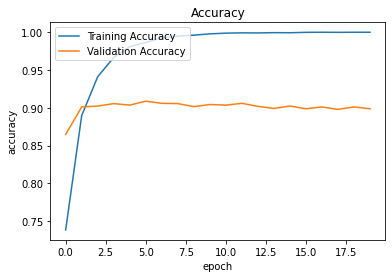

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

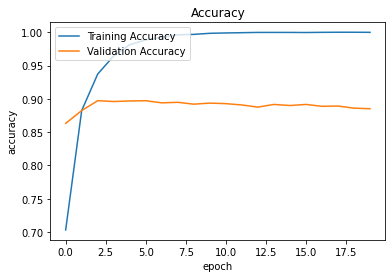

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

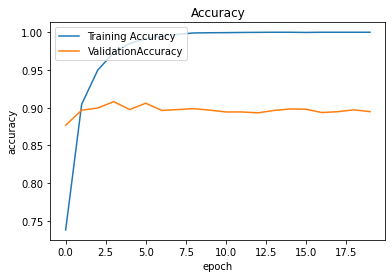

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
# Insert lists of accuracy obtained on the validation set
#plt.plot('acc', marker='o')
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
# Add extra descriptions to plot
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
# Display the plot
plt.savefig('m1acc.png', dpi=600)
plt.show()
files.download("m1acc.png") 


#plt.plot('acc', marker='o')
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
# Add extra descriptions to plot
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
# Display the plot
plt.savefig('m2acc.png', dpi=600)
plt.show()
files.download("m2acc.png") 


#plt.plot('acc', marker='o')
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
# Add extra descriptions to plot
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training Accuracy', 'ValidationAccuracy'], loc='upper left')
# Display the plot
plt.savefig('m3acc.png', dpi=600)
plt.show()
files.download("m3acc.png") 

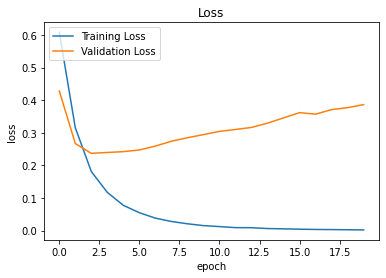

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

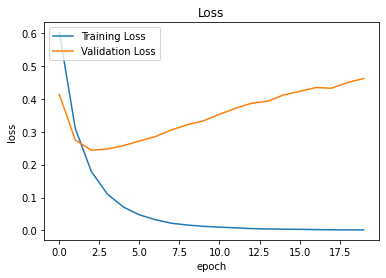

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

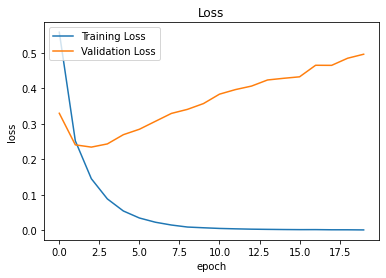

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [38]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
# Add extra descriptions to plot
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training Loss','Validation Loss'], loc='upper left')
# Display the plot
plt.savefig('m1loss.png', dpi=600)
plt.show()
files.download("m1loss.png") 


plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
# Add extra descriptions to plot
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training Loss','Validation Loss'], loc='upper left')
# Display the plot
plt.savefig('m2loss.png', dpi=600)
plt.show()
files.download("m2loss.png") 


plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
# Add extra descriptions to plot
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training Loss','Validation Loss'], loc='upper left')
# Display the plot
plt.savefig('m3loss.png', dpi=600)
plt.show()
files.download("m3loss.png") 

In [39]:
loss1, accuracy1 = model1.evaluate(X_test,y_test, verbose=0)
print("Loss:\t{0}\nAccuracy:\t{1}".format(loss1, accuracy1))

loss2, accuracy2 = model2.evaluate(X_test,y_test, verbose=0)
print("Loss:\t{0}\nAccuracy:\t{1}".format(loss2, accuracy2))

loss3, accuracy3 = model3.evaluate(X_test,y_test, verbose=0)
print("Loss:\t{0}\nAccuracy:\t{1}".format(loss3, accuracy3))

Loss:	0.37450626492500305
Accuracy:	0.8989999890327454
Loss:	0.4450804591178894
Accuracy:	0.8884999752044678
Loss:	0.47225871682167053
Accuracy:	0.8955000042915344


Next session

In [40]:
model4 = get_model(embedding1, dropout2, neuron1)
model5 = get_model(embedding2, dropout2, neuron1)
model6 = get_model(embedding3, dropout2, neuron1)

In [41]:
history4 = model4.fit(X_train, y_train, epochs=20,batch_size=32,validation_data=(X_val,y_val))
history5 = model5.fit(X_train, y_train, epochs=20,batch_size=32,validation_data=(X_val,y_val))
history6 = model6.fit(X_train, y_train, epochs=20,batch_size=32,validation_data=(X_val,y_val))

Epoch 1/20
235/235 [==============================] - 4s 18ms/step - loss: 0.6701 - accuracy: 0.6561 - val_loss: 0.5846 - val_accuracy: 0.8324
Epoch 2/20
235/235 [==============================] - 4s 16ms/step - loss: 0.4494 - accuracy: 0.8584 - val_loss: 0.3401 - val_accuracy: 0.8844
Epoch 3/20
235/235 [==============================] - 4s 15ms/step - loss: 0.2524 - accuracy: 0.9192 - val_loss: 0.2627 - val_accuracy: 0.8972
Epoch 4/20
235/235 [==============================] - 4s 16ms/step - loss: 0.1650 - accuracy: 0.9487 - val_loss: 0.2406 - val_accuracy: 0.9016
Epoch 5/20
235/235 [==============================] - 4s 15ms/step - loss: 0.1182 - accuracy: 0.9653 - val_loss: 0.2339 - val_accuracy: 0.9044
Epoch 6/20
235/235 [==============================] - 4s 15ms/step - loss: 0.0868 - accuracy: 0.9761 - val_loss: 0.2394 - val_accuracy: 0.9024
Epoch 7/20
235/235 [==============================] - 4s 16ms/step - loss: 0.0680 - accuracy: 0.9812 - val_loss: 0.2419 - val_accuracy: 0.9032

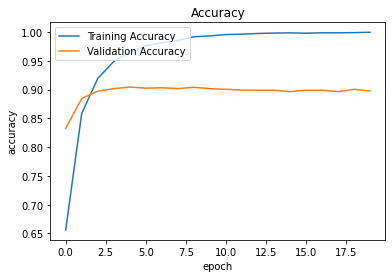

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

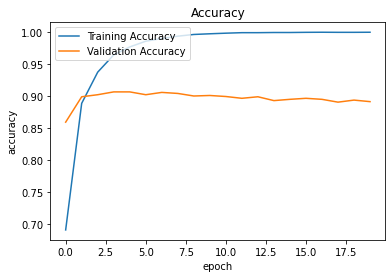

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

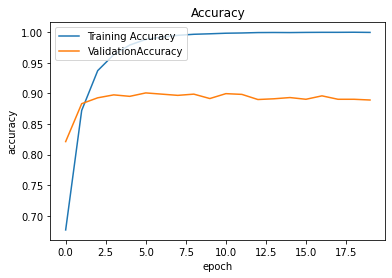

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [42]:
# Insert lists of accuracy obtained on the validation set
#plt.plot('acc', marker='o')
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
# Add extra descriptions to plot
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
# Display the plot
plt.savefig('m4acc.png', dpi=600)
plt.show()
files.download("m4acc.png") 


#plt.plot('acc', marker='o')
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
# Add extra descriptions to plot
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
# Display the plot
plt.savefig('m5acc.png', dpi=600)
plt.show()
files.download("m5acc.png") 


#plt.plot('acc', marker='o')
plt.plot(history6.history['accuracy'])
plt.plot(history6.history['val_accuracy'])
# Add extra descriptions to plot
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training Accuracy', 'ValidationAccuracy'], loc='upper left')
# Display the plot
plt.savefig('m6acc.png', dpi=600)
plt.show()
files.download("m6acc.png") 

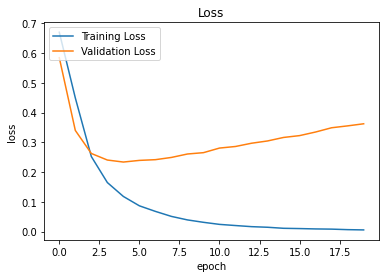

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

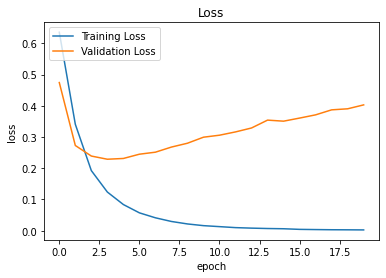

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

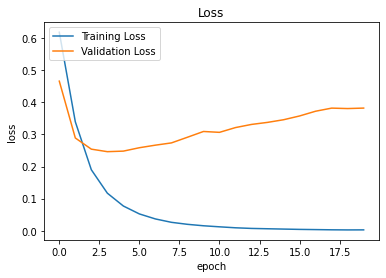

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [43]:
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
# Add extra descriptions to plot
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training Loss','Validation Loss'], loc='upper left')
# Display the plot
plt.savefig('m4loss.png', dpi=600)
plt.show()
files.download("m4loss.png") 


plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
# Add extra descriptions to plot
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training Loss','Validation Loss'], loc='upper left')
# Display the plot
plt.savefig('m5loss.png', dpi=600)
plt.show()
files.download("m5loss.png") 


plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
# Add extra descriptions to plot
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training Loss','Validation Loss'], loc='upper left')
# Display the plot
plt.savefig('m6loss.png', dpi=600)
plt.show()
files.download("m6loss.png") 

In [44]:
loss4, accuracy4 = model4.evaluate(X_test,y_test, verbose=0)
print("Loss:\t{0}\nAccuracy:\t{1}".format(loss4, accuracy4))

loss5, accuracy5 = model5.evaluate(X_test,y_test, verbose=0)
print("Loss:\t{0}\nAccuracy:\t{1}".format(loss5, accuracy5))

loss6, accuracy6 = model6.evaluate(X_test,y_test, verbose=0)
print("Loss:\t{0}\nAccuracy:\t{1}".format(loss6, accuracy6))

Loss:	0.3515533208847046
Accuracy:	0.9004999995231628
Loss:	0.3880546987056732
Accuracy:	0.8964999914169312
Loss:	0.37976905703544617
Accuracy:	0.8889999985694885


Third sessions

In [45]:
model7 = get_model(embedding1, dropout1, neuron1)
model8 = get_model(embedding1, dropout2, neuron1)
model9 = get_model(embedding1, dropout3, neuron1)

In [46]:
history7 = model7.fit(X_train, y_train, epochs=20,batch_size=32,validation_data=(X_val,y_val))
history8 = model8.fit(X_train, y_train, epochs=20,batch_size=32,validation_data=(X_val,y_val))
history9 = model9.fit(X_train, y_train, epochs=20,batch_size=32,validation_data=(X_val,y_val))

Epoch 1/20
235/235 [==============================] - 4s 16ms/step - loss: 0.6502 - accuracy: 0.6405 - val_loss: 0.5316 - val_accuracy: 0.7920
Epoch 2/20
235/235 [==============================] - 4s 15ms/step - loss: 0.4270 - accuracy: 0.8277 - val_loss: 0.3887 - val_accuracy: 0.8300
Epoch 3/20
235/235 [==============================] - 4s 16ms/step - loss: 0.2913 - accuracy: 0.8865 - val_loss: 0.3418 - val_accuracy: 0.8460
Epoch 4/20
235/235 [==============================] - 4s 15ms/step - loss: 0.2116 - accuracy: 0.9220 - val_loss: 0.3256 - val_accuracy: 0.8524
Epoch 5/20
235/235 [==============================] - 4s 16ms/step - loss: 0.1551 - accuracy: 0.9465 - val_loss: 0.3177 - val_accuracy: 0.8616
Epoch 6/20
235/235 [==============================] - 4s 15ms/step - loss: 0.1188 - accuracy: 0.9613 - val_loss: 0.3208 - val_accuracy: 0.8700
Epoch 7/20
235/235 [==============================] - 4s 15ms/step - loss: 0.0904 - accuracy: 0.9736 - val_loss: 0.3287 - val_accuracy: 0.8664

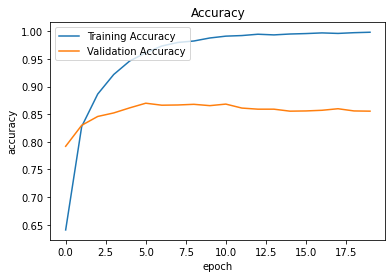

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

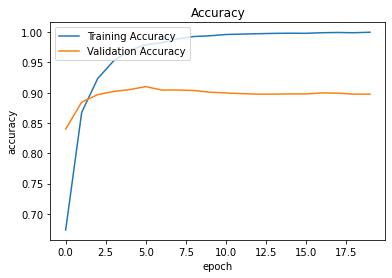

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

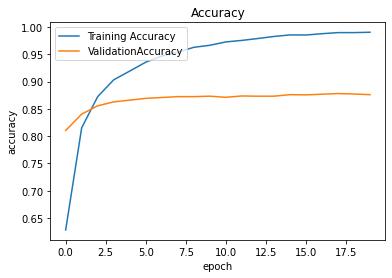

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [47]:
# Insert lists of accuracy obtained on the validation set
#plt.plot('acc', marker='o')
plt.plot(history7.history['accuracy'])
plt.plot(history7.history['val_accuracy'])
# Add extra descriptions to plot
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
# Display the plot
plt.savefig('m7acc.png', dpi=600)
plt.show()
files.download("m7acc.png") 


#plt.plot('acc', marker='o')
plt.plot(history8.history['accuracy'])
plt.plot(history8.history['val_accuracy'])
# Add extra descriptions to plot
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
# Display the plot
plt.savefig('m8acc.png', dpi=600)
plt.show()
files.download("m8acc.png") 


#plt.plot('acc', marker='o')
plt.plot(history9.history['accuracy'])
plt.plot(history9.history['val_accuracy'])
# Add extra descriptions to plot
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training Accuracy', 'ValidationAccuracy'], loc='upper left')
# Display the plot
plt.savefig('m9acc.png', dpi=600)
plt.show()
files.download("m9acc.png") 

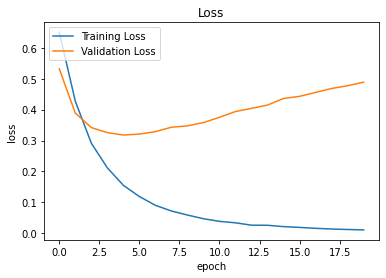

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

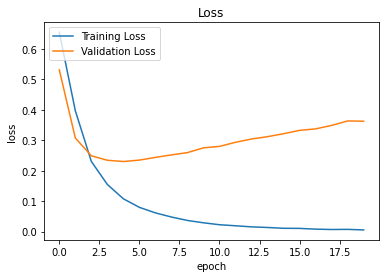

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

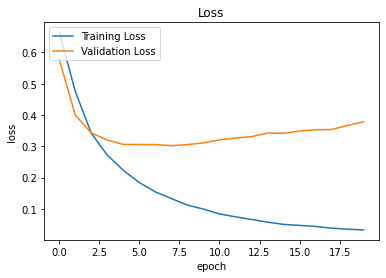

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [48]:
plt.plot(history7.history['loss'])
plt.plot(history7.history['val_loss'])
# Add extra descriptions to plot
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training Loss','Validation Loss'], loc='upper left')
# Display the plot
plt.savefig('m7loss.png', dpi=600)
plt.show()
files.download("m7loss.png") 


plt.plot(history8.history['loss'])
plt.plot(history8.history['val_loss'])
# Add extra descriptions to plot
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training Loss','Validation Loss'], loc='upper left')
# Display the plot
plt.savefig('m8loss.png', dpi=600)
plt.show()
files.download("m8loss.png") 


plt.plot(history9.history['loss'])
plt.plot(history9.history['val_loss'])
# Add extra descriptions to plot
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training Loss','Validation Loss'], loc='upper left')
# Display the plot
plt.savefig('m9loss.png', dpi=600)
plt.show()
files.download("m9loss.png") 

In [49]:
loss7, accuracy7 = model7.evaluate(X_test, y_test, verbose=0)
print("Loss:\t{0}\nAccuracy:\t{1}".format(loss7, accuracy7))

loss8, accuracy8 = model8.evaluate(X_test, y_test, verbose=0)
print("Loss:\t{0}\nAccuracy:\t{1}".format(loss8, accuracy8))

loss9, accuracy9 = model9.evaluate(X_test, y_test, verbose=0)
print("Loss:\t{0}\nAccuracy:\t{1}".format(loss9, accuracy9))

Loss:	0.48105868697166443
Accuracy:	0.8575000166893005
Loss:	0.3533805310726166
Accuracy:	0.8985000252723694
Loss:	0.355317622423172
Accuracy:	0.8794999718666077


FINAL ANALYSIS

In [50]:
from google.colab import files
uploaded = files.upload()

Saving GTNT.csv to GTNT.csv


In [52]:
df = pd.read_csv("GTNT.csv", delimiter=',', header=None,names=['id', 't','label'])

In [53]:
# Prepare predicted labels
df = df.iloc[1:]
Y = df.label
Y_series=pd.Series(Y,dtype='category')
Y = Y_series.cat.codes
y_prep = to_categorical(Y)
print(y_prep.shape)
print(Y_series)

(31103, 2)
1        0.0
2        0.0
3        0.0
4        0.0
5        0.0
        ... 
31099    1.0
31100    1.0
31101    1.0
31102    1.0
31103    1.0
Name: label, Length: 31103, dtype: category
Categories (2, object): [0.0, 1.0]


In [54]:
# Create and fit tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.t)
vocab_size = len(tokenizer.word_index) + 1
word_index = tokenizer.word_index
prep_data = tokenizer.texts_to_sequences(df.t)

In [55]:
prep_data = pad_sequences(prep_data, maxlen=200,padding="post")

In [56]:
print(len(prep_data))
print(len(Y))

31103
31103


In [57]:
# prepare train, test and validation data
X_train, X_test, y_train, y_test = train_test_split(prep_data, y_prep, test_size=0.2, random_state=42)

In [58]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [59]:
model_final = get_model(embedding1,dropout2,neuron1)

In [60]:
class_weight = dict()
class_weight[0] = 1	#  GT
class_weight[1] = 3	# NT

history_final = model_final.fit(X_train, y_train, epochs=20,batch_size=32,validation_data=(X_val,y_val),class_weight=class_weight)

Epoch 1/20
584/584 [==============================] - 12s 21ms/step - loss: 0.7563 - accuracy: 0.7402 - val_loss: 0.3047 - val_accuracy: 0.8738
Epoch 2/20
584/584 [==============================] - 12s 20ms/step - loss: 0.3375 - accuracy: 0.9149 - val_loss: 0.2209 - val_accuracy: 0.9122
Epoch 3/20
584/584 [==============================] - 12s 21ms/step - loss: 0.2183 - accuracy: 0.9471 - val_loss: 0.2087 - val_accuracy: 0.9143
Epoch 4/20
584/584 [==============================] - 12s 21ms/step - loss: 0.1536 - accuracy: 0.9628 - val_loss: 0.2070 - val_accuracy: 0.9171
Epoch 5/20
584/584 [==============================] - 12s 20ms/step - loss: 0.1138 - accuracy: 0.9730 - val_loss: 0.2016 - val_accuracy: 0.9212
Epoch 6/20
584/584 [==============================] - 12s 20ms/step - loss: 0.0876 - accuracy: 0.9797 - val_loss: 0.2062 - val_accuracy: 0.9248
Epoch 7/20
584/584 [==============================] - 12s 20ms/step - loss: 0.0686 - accuracy: 0.9848 - val_loss: 0.2149 - val_accuracy:

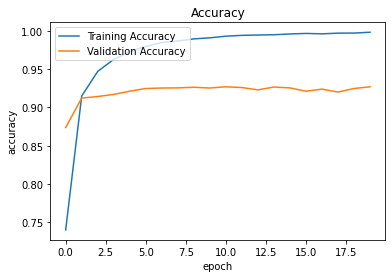

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [61]:
# Insert lists of accuracy obtained on the validation set
#plt.plot('acc', marker='o')
plt.plot(history_final.history['accuracy'])
plt.plot(history_final.history['val_accuracy'])
# Add extra descriptions to plot
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
# Display the plot
plt.savefig('mfinalacc.png', dpi=600)
plt.show()
files.download("mfinalacc.png") 

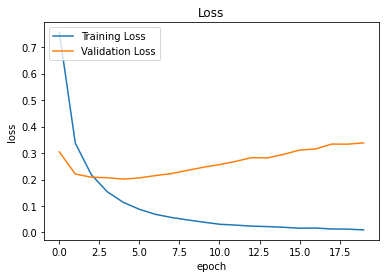

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [62]:
plt.plot(history_final.history['loss'])
plt.plot(history_final.history['val_loss'])
# Add extra descriptions to plot
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training Loss','Validation Loss'], loc='upper left')
# Display the plot
plt.savefig('mfinalloss.png', dpi=600)
plt.show()
files.download("mfinalloss.png") 

In [63]:
loss_final, accuracy_final = model_final.evaluate(X_test, y_test, verbose=0)
print("Loss:\t{0}\nAccuracy:\t{1}".format(loss_final, accuracy_final))

Loss:	0.34503746032714844
Accuracy:	0.922199010848999


In [64]:
predicted = model_final.predict(X_test)
# see the predicted
print(predicted)   

[[9.9999964e-01 3.2713837e-07]
 [9.9757534e-01 2.2012985e-03]
 [9.9999976e-01 2.0833087e-07]
 ...
 [9.9912030e-01 7.4475922e-04]
 [2.3348242e-04 9.9969804e-01]
 [2.5891732e-02 9.7536600e-01]]


In [65]:
# changing the format of y_preds and y_tests to make the assessment of the network
idx = np.argmax(predicted, axis=-1)
y_preds= np.zeros(predicted.shape )
y_preds[np.arange(predicted.shape[0]), idx] = 1

print(y_preds)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [66]:
idx = np.argmax(y_test, axis=-1)
y_tests= np.zeros(y_test.shape )
y_tests[np.arange(y_test.shape[0]), idx] = 1

print(y_tests)

[[1. 0.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [67]:
# Create the performance report
print(classification_report(y_tests, y_preds))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      4634
           1       0.85      0.84      0.85      1587

   micro avg       0.92      0.92      0.92      6221
   macro avg       0.90      0.90      0.90      6221
weighted avg       0.92      0.92      0.92      6221
 samples avg       0.92      0.92      0.92      6221

